<a href="https://colab.research.google.com/github/TheS1n233/Distributed-Learning-Project5/blob/experiments/LocalSGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade torch


# Imports

In [ ]:
import torch
import argparse
from torch.optim.optimizer import Optimizer, required
import torch
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
import json
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR
import matplotlib.pyplot as plt
import copy
import time
from torch.amp import GradScaler, autocast
import os
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
if not os.path.exists('/content/drive/MyDrive'):
    raise RuntimeError("Google Drive not mounted correctly!")

Mounted at /content/drive


## Model

In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5)

        # Layer fully connected
        self.fc1 = nn.Linear(64 * 5 * 5, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        # Layer convolutivi con ReLU e max-pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        # Flatten per i layer fully connected
        x = torch.flatten(x, 1)

        # Layer fully connected con ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)

        return x

## Early stopping

In [ ]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10, delta=0, path='/content/drive/MyDrive/Early2checkpoint.pt', verbose=False):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path
        self.verbose = verbose

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimizer=None):
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...")
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict() if optimizer else None,
            'val_loss_min': val_loss
        }
        torch.save(checkpoint, self.path)
        self.val_loss_min = val_loss



## Training function

In [ ]:
def train_model_with_hyperparams(train_loader, val_loader, test_loader, hyperparams, num_epochs, device, checkpoint_path, type_of_optimizer):
    model = LeNet5().to(device)

    if type_of_optimizer == "SGDM":
        if hyperparams.get('momentum', None) is None:
            raise ValueError("Momentum is required for SGDM")
        if hyperparams.get('weight_decay', None) is None:
            raise ValueError("Weight decay is required for SGDM")
        if hyperparams.get('lr', None) is None:
            raise ValueError("Learning rate is required for SGDM")

        optimizer = optim.SGD(
            model.parameters(),
            lr=hyperparams['lr'],
            momentum=hyperparams['momentum'],
            weight_decay=hyperparams['weight_decay']
        )

    elif type_of_optimizer == "AdamW":
        if hyperparams.get('lr', None) is None:
            raise ValueError("Learning rate is required for AdamW")
        if hyperparams.get('weight_decay', None) is None:
            raise ValueError("Weight decay is required for AdamW")

        optimizer = optim.AdamW(
            model.parameters(),
            lr=hyperparams['lr'],
            weight_decay=hyperparams['weight_decay'],
            eps=hyperparams['eps']
        )

    elif type_of_optimizer == "LAMB":
        if hyperparams.get('lr', None) is None:
            raise ValueError("Learning rate is required for LAMB")
        if hyperparams.get('weight_decay', None) is None:
            raise ValueError("Weight decay is required for LAMB")

        optimizer = LAMB(
            model.parameters(),
            lr=hyperparams['lr'],
            weight_decay=hyperparams['weight_decay'],
            betas=hyperparams.get('betas', (0.9, 0.999)),
            eps=hyperparams.get('eps', 1e-6)
        )

    elif type_of_optimizer == "LARS":
        if hyperparams.get('lr', None) is None:
            raise ValueError("Learning rate is required for LARS")
        if hyperparams.get('weight_decay', None) is None:
            raise ValueError("Weight decay is required for LARS")

        optimizer = LARS(
            model.parameters(),
            lr=hyperparams['lr'],
            weight_decay=hyperparams['weight_decay'],
            momentum=hyperparams.get('momentum', 0.9),
            eta=hyperparams.get('eta', 0.001),
            eps=hyperparams.get('eps', 1e-8)
        )
    else:
        raise ValueError("Invalid optimizer type")


    #warmup_scheduler = LinearLR(optimizer, start_factor=0.1, total_iters=5)
    #scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, CosineAnnealingLR(optimizer, T_max=num_epochs - 5)], milestones=[5])


    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    early_stopping = EarlyStopping(patience=hyperparams.get('patience', 5) , verbose=True)

    # Checkpoint recovery
    start_epoch = 0
    """if os.path.exists(checkpoint_path):
        print(f"Checkpoint found at {checkpoint_path}. Loading model state...")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Resuming training from epoch {start_epoch + 1}")
    else:
        print(f"No checkpoint found at {checkpoint_path}. Training a new model from scratch.")"""
    checkpoint = None

    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    scaler = GradScaler()

    for epoch in range(num_epochs):
        model.train()
        train_loss_total, train_correct, train_total = 0, 0, 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()

            with autocast(device_type=device.type):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss_total += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_loss = train_loss_total / len(train_loader)
        train_acc = 100. * train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation loop
        model.eval()
        val_loss_total, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                with autocast(device_type=device.type):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_loss_total += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss_total / len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        scheduler.step()
        early_stopping(val_loss, model)

        # Save checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }

        torch.save(checkpoint, '/content/drive/MyDrive/CentralizedCheckpoint.pth')
        print(f"Checkpoint saved to Google Drive at epoch {epoch + 1}")

        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Load the best model
    checkpoint = torch.load('/content/drive/MyDrive/Early2checkpoint.pt')
    model.load_state_dict(checkpoint['model_state_dict'])

    # Test loop
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            with autocast(device_type=device.type):
                outputs = model(inputs)

            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    test_acc = 100. * test_correct / test_total
    print(f"Final Test Accuracy: {test_acc:.2f}%")
    return train_losses, val_losses, train_accuracies, val_accuracies, test_acc

## Defining different optimizers

In [ ]:

class LARS(Optimizer):
    def __init__(self, params, lr=0.1, momentum=0.9, weight_decay=0.0, eta=0.001, eps=1e-8):
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if momentum < 0.0 or momentum >= 1.0:
            raise ValueError(f"Invalid momentum: {momentum}")
        if weight_decay < 0.0:
            raise ValueError(f"Invalid weight_decay: {weight_decay}")
        if eta <= 0.0:
            raise ValueError(f"Invalid eta: {eta}")

        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay, eta=eta, eps=eps)
        super(LARS, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            momentum = group['momentum']
            weight_decay = group['weight_decay']
            eta = group['eta']
            eps = group['eps']

            for param in group['params']:
                if param.grad is None:
                    continue

                grad = param.grad.data
                if grad.isinf().any() or grad.isnan().any():
                    print(f"Skipping update for parameter {param} due to NaN/Inf gradients.")
                    continue

                if weight_decay != 0:
                    grad.add_(param.data, alpha=weight_decay)

                param_norm = param.data.norm(2).clamp(min=eps)
                grad_norm = grad.norm(2).clamp(min=eps)
                local_lr = eta * param_norm / grad_norm

                if 'momentum_buffer' not in self.state[param]:
                    buf = self.state[param]['momentum_buffer'] = torch.clone(grad).detach()
                else:
                    buf = self.state[param]['momentum_buffer']
                    buf.mul_(momentum).add_(grad)

                param.data.add_(buf, alpha=-local_lr * lr)

        return loss


class LAMB(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-6, weight_decay=0.01):
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")
        if weight_decay < 0.0:
            raise ValueError(f"Invalid weight_decay value: {weight_decay}")

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(LAMB, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            betas = group['betas']
            eps = group['eps']
            weight_decay = group['weight_decay']

            for param in group['params']:
                if param.grad is None:
                    continue

                grad = param.grad.data
                if grad.isinf().any() or grad.isnan().any():
                    print(f"Skipping update for parameter {param} due to NaN/Inf gradients.")
                    continue

                state = self.state[param]
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(param.data)
                    state['exp_avg_sq'] = torch.zeros_like(param.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = betas
                state['step'] += 1

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                denom = exp_avg_sq.sqrt().add_(eps)
                r1 = param.data.norm(2).clamp(min=eps)
                r2 = exp_avg.norm(2).clamp(min=eps)
                trust_ratio = r1 / r2 if r2 != 0 else 1.0

                step_size = lr * trust_ratio
                if weight_decay != 0:
                    param.data.add_(param.data, alpha=-weight_decay)

                param.data.addcdiv_(exp_avg, denom, value=-step_size)

        return loss


In [ ]:
def parse_args():
    parser = argparse.ArgumentParser(description='Large-Batch Optimizer Selection')
    parser.add_argument('--optimizer', type=str, default='SGDM', choices=['SGDM', 'AdamW', 'LARS', 'LAMB'],
                        help='Select optimizer (SGDM, AdamW, LARS, LAMB)')
    #parser.add_argument('--lr', type=float, default=1e-3, help='Learning rate')
    #parser.add_argument('--batch_size', type=int, default=32, help='Batch size')
    args = parser.parse_args()
    return args


## Function to get train, test and val dataset

In [ ]:
def get_dataset(batch_size):
    batch_size=batch_size
    print("batch_size", batch_size)
    # Define the transform to only convert the images to tensors (without normalization yet)
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Load the CIFAR-100 training dataset
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )


    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False, num_workers=2)

    # Initialize sums for calculating mean and std
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for images, _ in train_loader:
        # Compute mean and std for each channel
        mean += images.mean(dim=[0, 2, 3])
        std += images.std(dim=[0, 2, 3])

    mean /= len(train_loader)
    std /= len(train_loader)

    print("Mean: ", mean)
    print("Std: ", std)

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                            std=[std[0].item(), std[1].item(), std[2].item()])
    ])

    transform_test = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                            std=[std[0].item(), std[1].item(), std[2].item()])
    ])

    # Load CIFAR-100 dataset
    start_time = time.time()
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=False,
        download=True,
        transform=transform_test
    )
    print(f"Dataset loading time: {time.time() - start_time:.2f} seconds")

    # Split training and validation sets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # Data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Debugging: Check DataLoader outputs
    for i, (inputs, labels) in enumerate(train_loader):
        print(f"Batch {i}: inputs shape: {inputs.shape}, labels shape: {labels.shape}")
        if i == 10:  # Test first 10 batches
            break
    print(f"Data loading for 10 batches completed.")
    print(f"Training dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")

    return train_loader, val_loader, test_loader

# LocalSGD

In [ ]:
def local_sgd(train_dataset, val_loader, test_loader, device, num_workers, local_steps, num_epoch, batch_size, hyperparams, checkpoint_path):
    # Calculate adjusted epochs based on J and K
    total_samples = len(train_dataset)
    batches_per_epoch_centralized = total_samples // batch_size
    batches_per_epoch_per_worker = total_samples // num_workers // batch_size
    batches_per_sync = local_steps * num_workers
    adjusted_epochs = num_epoch * batches_per_epoch_centralized // (batches_per_sync * batches_per_epoch_per_worker)

    print(f"Adjusted epochs for : {adjusted_epochs} K={num_workers}, J={local_steps}")

    # Initialize the global model and optimizer
    global_model = LeNet5().to(device)
    global_optimizer = optim.SGD(global_model.parameters(), lr=hyperparams['lr'], weight_decay=hyperparams['weight_decay'], momentum=hyperparams['momentum'])
    global_scheduler = CosineAnnealingLR(global_optimizer, T_max=adjusted_epochs)
    criterion = nn.CrossEntropyLoss()

    # Split the training dataset into K subsets
    split_sizes = [len(train_dataset) // num_workers] * num_workers
    split_sizes[-1] += len(train_dataset) % num_workers
    dataset_split = torch.utils.data.random_split(train_dataset, split_sizes)
    train_loaders = [torch.utils.data.DataLoader(subset, batch_size, shuffle=True, num_workers=2, pin_memory=True) for subset in dataset_split]

    # Record training progress
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    # Train each worker locally
    for epoch in range(adjusted_epochs):
        global_model.train()

        # Initialize a dictionary to store the sum of all workers' parameters
        aggregated_params = {key: torch.zeros_like(value) for key, value in global_model.state_dict().items()}

        # Train each worker locally and accumulate their parameters
        for worker_id, train_loader in enumerate(train_loaders):
            # Clone the global model for each worker
            local_model = LeNet5().to(device)
            local_model.load_state_dict(global_model.state_dict())

            # Define the optimizer for the local model
            local_optimizer = optim.SGD(local_model.parameters(), lr=hyperparams['lr'],weight_decay=hyperparams['weight_decay'], momentum=hyperparams['momentum'])

            # Train locally for `local_steps`
            for step, (inputs, labels) in enumerate(train_loader):
                if step >= local_steps:
                    break

                inputs, labels = inputs.to(device), labels.to(device)
                local_optimizer.zero_grad()
                outputs = local_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                local_optimizer.step()

            # Accumulate worker's parameters to the global parameter dictionary
            for key, value in local_model.state_dict().items():
                aggregated_params[key] += value

        # Average the accumulated parameters across all workers
        for key in aggregated_params:
            aggregated_params[key] /= num_workers

        # Update the global model with the averaged parameters
        global_model.load_state_dict(aggregated_params)

        # Adjust learning rate using the global scheduler
        global_scheduler.step()

        # Validate performance
        global_model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = global_model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}/{adjusted_epochs} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save checkpoint
        torch.save(global_model.state_dict(), checkpoint_path)


    # Test performance
    global_model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = global_model(inputs)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    test_acc = 100. * test_correct / test_total
    print(f"Final Test Accuracy: {test_acc:.2f}%")
    return train_losses, val_losses, val_accuracies, test_acc


if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    num_epoch=150
    batch_size=64
    num_workers_list = [2, 4, 8]
    local_steps_list = [4, 8, 16, 32, 64]
    hyperparams = {
        'lr': 0.01,
        'weight_decay': 0.005,
        'momentum': 0.9,
    }

    train_loader, val_loader, test_loader = get_dataset(batch_size)   # modify batch size
    train_dataset = train_loader.dataset

    for num_workers in num_workers_list:
        for local_steps in local_steps_list:
            print(f"Running LocalSGD with {num_workers} workers and {local_steps} local steps")
            train_losses, val_losses, val_accuracies, test_acc = local_sgd(
                train_dataset=train_dataset,
                val_loader=val_loader,
                test_loader=test_loader,
                device=device,
                num_workers=num_workers,
                local_steps=local_steps,
                num_epoch=num_epoch,
                batch_size=batch_size,
                hyperparams=hyperparams,
                checkpoint_path=f"/content/drive/MyDrive/LocalSGD_{num_workers}_{local_steps}.pth"
            )


batch_size 64
Files already downloaded and verified
Mean:  tensor([0.5070, 0.4865, 0.4408])
Std:  tensor([0.2664, 0.2555, 0.2750])
Files already downloaded and verified
Files already downloaded and verified
Dataset loading time: 1.82 seconds
Batch 0: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 1: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 2: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 3: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 4: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 5: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 6: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 7: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 8: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 9: in

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f421d0d6830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7f421d0d6830>

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    
if w.is_alive():AssertionError: can only test a child process

  File "/usr/lib/

Final Test Accuracy: 2.31%
Running LocalSGD with 2 workers and 32 local steps
Adjusted epochs for : 4 K=2, J=32


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f421d0d6830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f421d0d6830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 1/4 | Val Loss: 4.6037, Val Acc: 1.33%
Epoch 2/4 | Val Loss: 4.5993, Val Acc: 1.50%
Epoch 3/4 | Val Loss: 4.5887, Val Acc: 1.71%
Epoch 4/4 | Val Loss: 4.5650, Val Acc: 2.31%
Final Test Accuracy: 2.67%
Running LocalSGD with 2 workers and 64 local steps
Adjusted epochs for : 2 K=2, J=64
Epoch 1/2 | Val Loss: 4.5974, Val Acc: 1.28%
Epoch 2/2 | Val Loss: 4.5381, Val Acc: 1.97%
Final Test Accuracy: 1.89%
Running LocalSGD with 4 workers and 4 local steps
Adjusted epochs for : 37 K=4, J=4
Epoch 1/37 | Val Loss: 4.6078, Val Acc: 1.08%
Epoch 2/37 | Val Loss: 4.6076, Val Acc: 1.13%
Epoch 3/37 | Val Loss: 4.6075, Val Acc: 1.13%
Epoch 4/37 | Val Loss: 4.6072, Val Acc: 1.16%
Epoch 5/37 | Val Loss: 4.6071, Val Acc: 1.29%
Epoch 6/37 | Val Loss: 4.6069, Val Acc: 1.34%
Epoch 7/37 | Val Loss: 4.6068, Val Acc: 1.42%
Epoch 8/37 | Val Loss: 4.6067, Val Acc: 1.14%
Epoch 9/37 | Val Loss: 4.6065, Val Acc: 1.26%
Epoch 10/37 | Val Loss: 4.6063, Val Acc: 1.32%
Epoch 11/37 | Val Loss: 4.6061, Val Acc: 1.29%

Exception in thread Thread-923 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/pin_memory.py", line 35, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.10/dist-packages/torch/multiprocessing/reductions.py", line 541, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.10/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python

KeyboardInterrupt: 

## Main

batch_size 64


100%|██████████| 169M/169M [00:04<00:00, 39.9MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Mean:  tensor([0.5071, 0.4865, 0.4409])
Std:  tensor([0.2667, 0.2558, 0.2754])
Files already downloaded and verified
Files already downloaded and verified
Dataset loading time: 1.79 seconds
Batch 0: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 1: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 2: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 3: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 4: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 5: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 6: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 7: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 8: inputs shape: torch.Size([64, 3, 32, 32]), labels shape: torch.Size([64])
Batch 9: in

<ipython-input-7-9c6bd9fd64c1>:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/Early2checkpoint.pt')


Final Test Accuracy: 46.80%
batch_size 128
Files already downloaded and verified
Mean:  tensor([0.5071, 0.4865, 0.4409])
Std:  tensor([0.2667, 0.2558, 0.2754])
Files already downloaded and verified
Files already downloaded and verified
Dataset loading time: 1.89 seconds
Batch 0: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Batch 1: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Batch 2: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Batch 3: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Batch 4: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Batch 5: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Batch 6: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Batch 7: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Batch 8: inputs shape: torch.Size([128, 3, 32, 32

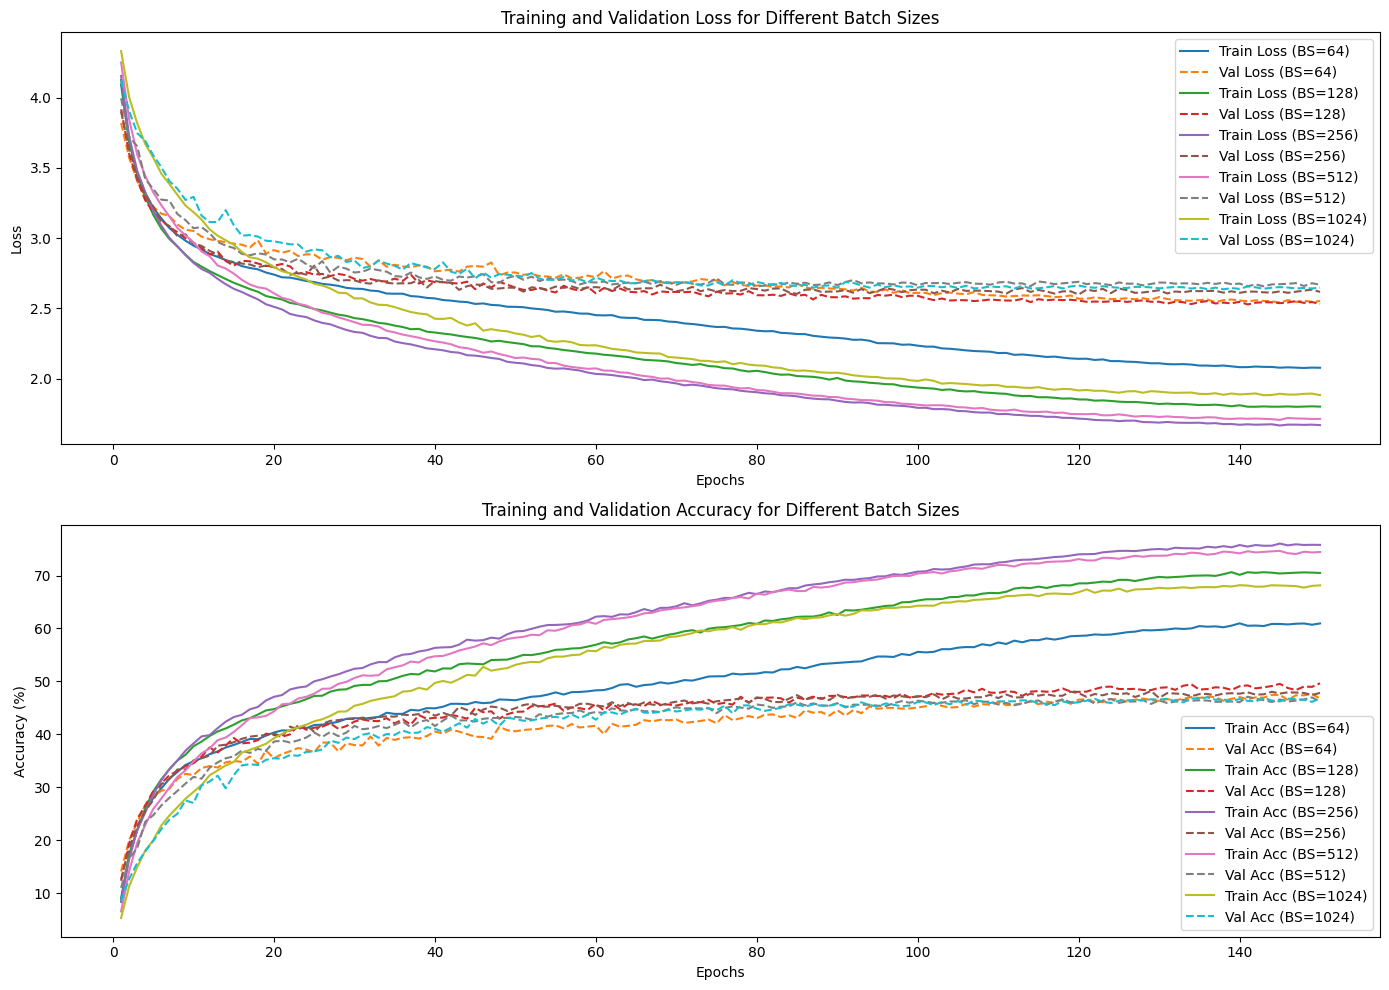

Training summaries saved to Google Drive as 'Batch_Size_Comparison_summary.txt'


In [ ]:
if __name__ == "__main__":

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    #args = parse_args()

    class Args:
        def __init__(self):
            self.optimizer = 'SGDM'  # Choose from: 'SGDM', 'AdamW', 'LARS', 'LAMB'
            #self.batch_size = 32

    args = Args() # replace "args = parse_args()" with this line


    all_train_losses = {}
    all_val_losses = {}
    all_train_accuracies = {}
    all_val_accuracies = {}
    all_test_accuracies = {}

    batch_sizes = [64, 128, 256, 512, 1024]

    for batch_size in batch_sizes:

        #model = LeNet5().to(device)
        train_loader, val_loader, test_loader = get_dataset(batch_size)

        """if args.optimizer == "AdamW":
            print("using AdamW optimizer...")
            optimizer = optim.AdamW(
                model.parameters(),
                lr=0.1 * (batch_size / 64),
                weight_decay=0.0001,
                eps=0.9
            )

        elif args.optimizer == "SGDM":
            print("using SDGM optimizer...")
            print(f"Running with params: lr={0.01 * (batch_size / 64)}, weight_decay={0.005} and batch size: {batch_size}")
        """
        """optimizer = optim.SGD(
                model.parameters(),
                lr=0.01 * (batch_size / 64),
                momentum=0.9,
                weight_decay=0.005
            )"""

        """else:
            raise ValueError("Invalid optimizer name")"""


        hyperparams = {
            'lr': 0.001,
            'weight_decay': 0.1,
            # 'momentum': 0.9,
            'eps': 0.0001,
            'patience': 100
        }

        # Train with the best hyperparameters
        train_losses, val_losses, train_accuracies, val_accuracies, test_acc = train_model_with_hyperparams(
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            hyperparams=hyperparams,
            num_epochs=150,
            device=device,
            checkpoint_path=f'/content/drive/MyDrive/checkpoint1-{batch_size}.pth',
            type_of_optimizer="AdamW"  # AdamW or SGDM, LAMB or LARS
        )


        # Salvataggio dei risultati
        all_train_losses[batch_size] = train_losses
        all_val_losses[batch_size] = val_losses
        all_train_accuracies[batch_size] = train_accuracies
        all_val_accuracies[batch_size] = val_accuracies
        all_test_accuracies[batch_size] = test_acc

    plt.figure(figsize=(14, 10))

    plt.subplot(2, 1, 1)
    for batch_size in batch_sizes:
        plt.plot(range(1, len(all_train_losses[batch_size]) + 1), all_train_losses[batch_size], label=f'Train Loss (BS={batch_size})')
        plt.plot(range(1, len(all_val_losses[batch_size]) + 1), all_val_losses[batch_size], '--', label=f'Val Loss (BS={batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss for Different Batch Sizes')
    plt.legend()

    plt.subplot(2, 1, 2)
    for batch_size in batch_sizes:
        plt.plot(range(1, len(all_train_accuracies[batch_size]) + 1), all_train_accuracies[batch_size], label=f'Train Acc (BS={batch_size})')
        plt.plot(range(1, len(all_val_accuracies[batch_size]) + 1), all_val_accuracies[batch_size], '--', label=f'Val Acc (BS={batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy for Different Batch Sizes')
    plt.legend()

    plt.tight_layout()

    save_path = '/content/drive/My Drive/Colab Notebooks/Traning_summary/Batch_Size_Comparison'
    plt.savefig(save_path + '_results.png')
    print("Batch size comparison results saved to Google Drive as 'Batch_Size_Comparison_results.png'")
    plt.show()

    summary_path = save_path + '_summary.txt'
    with open(summary_path, 'w') as f:
        for batch_size in batch_sizes:
            f.write(f"Batch Size: {batch_size}\n")
            f.write(f"Final Test Accuracy: {all_test_accuracies[batch_size]:.2f}%\n")
            f.write(f"Train Losses: {all_train_losses[batch_size]}\n")
            f.write(f"Validation Losses: {all_val_losses[batch_size]}\n")
            f.write(f"Train Accuracies: {all_train_accuracies[batch_size]}\n")
            f.write(f"Validation Accuracies: {all_val_accuracies[batch_size]}\n")
            f.write("\n")
    print(f"Training summaries saved to Google Drive as 'Batch_Size_Comparison_summary.txt'")